get pokemon data(only final evolution) using pokeapi

In [10]:
import requests
import pandas as pd
import time

def get_weaknesses(types):
    weakness_set = set()
    for t in types:
        type_url = f"https://pokeapi.co/api/v2/type/{t}/"
        type_data = requests.get(type_url).json()
        for weak in type_data['damage_relations']['double_damage_from']:
            weakness_set.add(weak['name'])
        time.sleep(0.1)  # be polite to API
    return list(weakness_set)

def get_final_evolutions(max_pokemon=100):
    """
    Return a set of names (in lowercase) of all final evolution Pokémon within the first max_pokemon entries.
    """
    base_url = "https://pokeapi.co/api/v2/pokemon?limit=" + str(max_pokemon)
    pokemon_list = requests.get(base_url).json()["results"]
    final_forms = set()

    for p in pokemon_list:
        try:
            species_url = requests.get(f"https://pokeapi.co/api/v2/pokemon/{p['name']}").json()["species"]["url"]
            species_data = requests.get(species_url).json()
            evo_chain_url = species_data["evolution_chain"]["url"]
            evo_chain = requests.get(evo_chain_url).json()["chain"]

            def get_final_forms(chain):
                if not chain["evolves_to"]:
                    return [chain["species"]["name"]]
                final_forms_local = []
                for evo in chain["evolves_to"]:
                    final_forms_local.extend(get_final_forms(evo))
                return final_forms_local

            final_evos = get_final_forms(evo_chain)
            final_forms.update(final_evos)
            time.sleep(0.1)
        except:
            continue  # skip if any issue

    return final_forms

def get_pokemon_data(max_pokemon=100, batch_size=50):
    base_url = "https://pokeapi.co/api/v2/pokemon"
    results = []
    offset = 0

    # Get final forms before collecting full data
    print("Getting final evolution list...")
    final_forms = get_final_evolutions(max_pokemon)
    print(f"Found {len(final_forms)} final evolution Pokémon.")

    while offset < max_pokemon:
        print(f"Fetching batch starting at offset {offset}")
        url = f"{base_url}?offset={offset}&limit={batch_size}"
        response = requests.get(url).json()

        for pokemon in response["results"]:
            name = pokemon["name"]
            if name not in final_forms:
                continue  # skip non-final evolution

            detail_url = pokemon["url"]
            detail = requests.get(detail_url).json()

            stats = {s["stat"]["name"]: s["base_stat"] for s in detail["stats"]}
            stats["name"] = name.title()

            # Get types
            types = [t["type"]["name"] for t in detail["types"]]
            stats["types"] = ", ".join(types)

            # Get weaknesses from type API
            weaknesses = get_weaknesses(types)
            stats["weaknesses"] = ", ".join(weaknesses)

            results.append(stats)
            time.sleep(0.2)

        offset += batch_size

    return results

# Example usage:
data = get_pokemon_data(max_pokemon=500)  # You can increase this to 500 or 1010
df = pd.DataFrame(data)
df.to_csv("final_evolution_pokemon.csv", index=False)
print("Saved to final_evolution_pokemon.csv")


Getting final evolution list...
Found 271 final evolution Pokémon.
Fetching batch starting at offset 0
Fetching batch starting at offset 50
Fetching batch starting at offset 100
Fetching batch starting at offset 150
Fetching batch starting at offset 200
Fetching batch starting at offset 250
Fetching batch starting at offset 300
Fetching batch starting at offset 350
Fetching batch starting at offset 400
Fetching batch starting at offset 450
Saved to final_evolution_pokemon.csv


In [2]:
import requests
import pandas as pd
import time
df = pd.read_csv("final_evolution_pokemon.csv")

EDA

In [12]:
df.groupby('types')['types'].count()

,types
types,
bug,4
"bug, fighting",1
"bug, flying",8
"bug, ghost",1
"bug, grass",1
...,...
"water, ice",3
"water, poison",1
"water, psychic",3


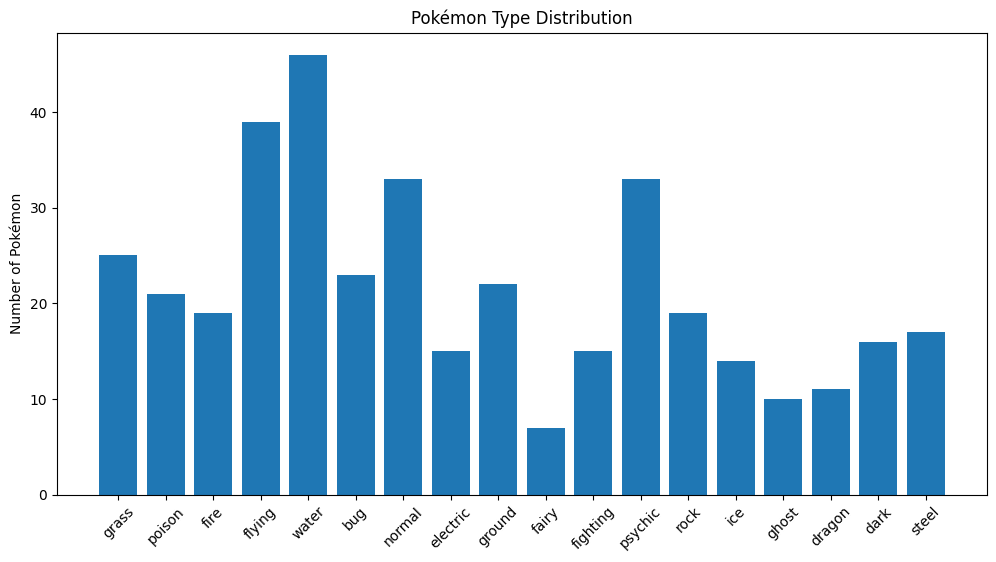

In [3]:
from collections import Counter
import matplotlib.pyplot as plt

# Assuming types are comma-separated in a string
type_counts = Counter()
for t in df["types"]:
    type_counts.update(t.split(", "))

# Plot
plt.figure(figsize=(12, 6))
plt.bar(type_counts.keys(), type_counts.values())
plt.title("Pokémon Type Distribution")
plt.xticks(rotation=45)
plt.ylabel("Number of Pokémon")
plt.show()


Which types are most commonly a weakness? How many pokemons are weak to each type.

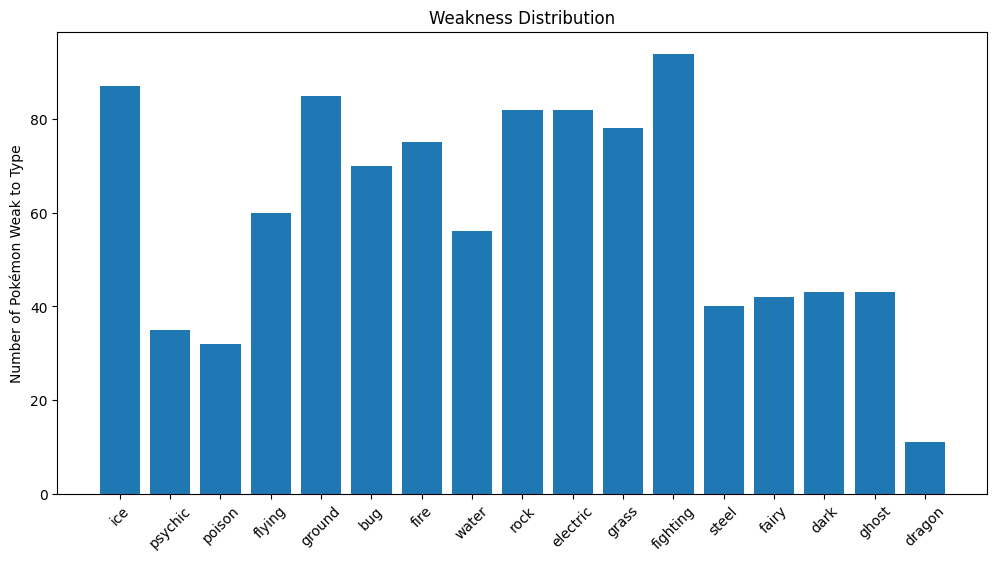

In [4]:
# Count weaknesses
weakness_counts = Counter()
for weakness_str in df["weaknesses"].dropna():
    for w in weakness_str.split(", "):  # split the comma-separated string
        weakness_counts[w] += 1

plt.figure(figsize=(12, 6))
plt.bar(weakness_counts.keys(), weakness_counts.values())
plt.title("Weakness Distribution")
plt.xticks(rotation=45)
plt.ylabel("Number of Pokémon Weak to Type")
plt.show()


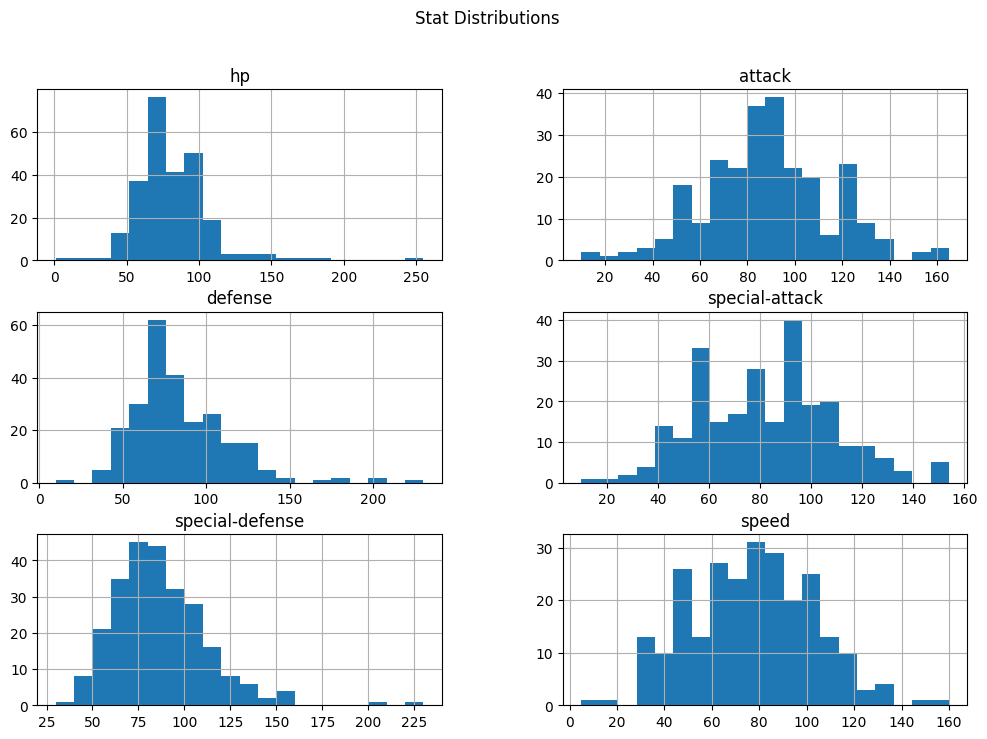

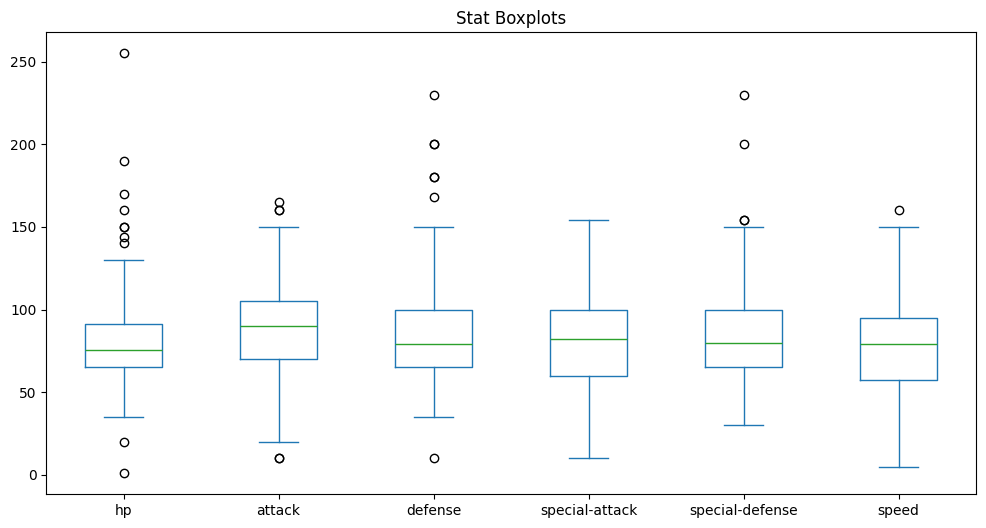

In [5]:
stat_cols = ['hp', 'attack', 'defense', 'special-attack', 'special-defense', 'speed']

df[stat_cols].hist(figsize=(12, 8), bins=20)
plt.suptitle("Stat Distributions")
plt.show()

# Boxplot
df[stat_cols].plot(kind="box", figsize=(12, 6), title="Stat Boxplots")
plt.show()


In [10]:
df["total_stat"] = df[stat_cols].sum(axis=1)
top_pokemon = df.sort_values("total_stat", ascending=False).head(10)
print("Top 10 pokemons")
print(top_pokemon[["name", "types", "total_stat"]])

Top 10 pokemons
          name              types  total_stat
248     Arceus           {normal}         720
112      Ho-Oh     {flying, fire}         680
64      Mewtwo          {psychic}         680
111      Lugia  {psychic, flying}         680
241     Dialga    {steel, dragon}         680
242     Palkia    {water, dragon}         680
183   Rayquaza   {flying, dragon}         680
244  Regigigas           {normal}         670
182    Groudon           {ground}         670
181     Kyogre            {water}         670


Use greedy algorithm to select team

In [19]:
# Convert weakness string to a set
df["weaknesses"] = df["weaknesses"].fillna("").apply(lambda x: set(x.split(", ")) if x else set())

def build_greedy_team(pool, team_size=6):
    team = []
    used_weaknesses = set()

    for p in sorted(pool, key=lambda x: len(x["weaknesses"])):
        if not p["weaknesses"].intersection(used_weaknesses):
            team.append(p)
            used_weaknesses.update(p["weaknesses"])
        if len(team) == team_size:
            break

    return team

# Use full data (or partial pool if needed)
pool = df.to_dict("records")
greedy_team = build_greedy_team(pool)

print(f"Greedy-selected team (no overlapping weaknesses):")
for p in greedy_team:
    print(f"- {p['name']:12} | Types: {p['types']} | Weaknesses: {', '.join(p['weaknesses'])}")


Greedy-selected team (no overlapping weaknesses):
- Raticate     | Types: normal | Weaknesses: fighting
- Raichu       | Types: electric | Weaknesses: ground
- Blastoise    | Types: water | Weaknesses: grass, electric
- Clefable     | Types: fairy | Weaknesses: steel, poison
- Banette      | Types: ghost | Weaknesses: dark, ghost
- Machamp      | Types: fighting | Weaknesses: fairy, flying, psychic


start with most effective pokemon

In [8]:
import pandas as pd
import time

# Load and prepare
df = pd.read_csv("final_evolution_pokemon.csv")
df["weaknesses"] = df["weaknesses"].fillna("").apply(lambda x: set(x.split(", ")) if x else set())
df["types"] = df["types"].fillna("").apply(lambda x: set(x.split(", ")) if x else set())

# Build a lookup of how many Pokémon are weak to each type
all_weaknesses = df["weaknesses"].tolist()
weakness_counter = {}
for w_set in all_weaknesses:
    for w in w_set:
        weakness_counter[w] = weakness_counter.get(w, 0) + 1

# Score each Pokémon by how many of their types match opponent weaknesses
def compute_coverage_score(p):
    return sum(weakness_counter.get(t, 0) for t in p["types"])

df["coverage_score"] = df.apply(compute_coverage_score, axis=1)

# Build greedy team
def build_strongest_team(pool, team_size=6):
    team = []
    used_weaknesses = set()
    used_names = set()

    # Sort by offensive effectiveness
    sorted_pool = sorted(pool, key=lambda x: x["coverage_score"], reverse=True)

    # First pass: pick Pokémon without overlapping weaknesses
    for p in sorted_pool:
        if not p["weaknesses"].intersection(used_weaknesses):
            team.append(p)
            used_names.add(p["name"])
            used_weaknesses.update(p["weaknesses"])
        if len(team) == team_size:
            return team  # done!

    # Second pass: fill remaining slots even if overlap exists
    for p in sorted_pool:
        if p["name"] not in used_names:
            team.append(p)
            used_names.add(p["name"])
        if len(team) == team_size:
            break

    return team


# Run the team builder
pool = df.to_dict("records")
greedy_team = build_strongest_team(pool)

# Output
print(f"Greedy-selected team (offensively strong with no overlapping weaknesses):")
for p in greedy_team:
    print(f"- {p['name']:12} | Types: {', '.join(p['types'])} | Weaknesses: {', '.join(p['weaknesses'])} | Coverage Score: {p['coverage_score']}")


Greedy-selected team (offensively strong with no overlapping weaknesses):
- Breloom      | Types: fighting, grass | Weaknesses: psychic, fairy, bug, flying, ice, poison, fire | Coverage Score: 172
- Magcargo     | Types: fire, rock | Weaknesses: steel, fighting, ground, rock, grass, water | Coverage Score: 157
- Banette      | Types: ghost | Weaknesses: ghost, dark | Coverage Score: 43
- Mamoswine    | Types: ice, ground | Weaknesses: steel, fighting, rock, grass, ice, water, fire | Coverage Score: 172
- Blaziken     | Types: fighting, fire | Weaknesses: psychic, fairy, ground, rock, flying, water | Coverage Score: 169
- Infernape    | Types: fighting, fire | Weaknesses: psychic, fairy, ground, rock, flying, water | Coverage Score: 169


add roles into consideration: problem: some first or second stage pokemon have low stats and considered to be support

In [45]:
def assign_role(p):
    hp, atk, df, spatk, spdef, spd = p["hp"], p["attack"], p["defense"], p["special-attack"], p["special-defense"], p["speed"]

# Glass Cannon: very fast, very offensive, very fragile
    if spd >= 100 and (atk >= 90 or spatk >= 90) and df < 75 and spdef < 75:
        return "Glass Cannon"

    # Physical Sweeper: fast and high attack, moderate defenses
    if atk >= 90 and spd >= 85:
        return "Physical Sweeper"

    # Special Sweeper: fast and high special attack, moderate defenses
    if spatk >= 90 and spd >= 85:
        return "Special Sweeper"

    # Tank: high HP and at least one strong defense
    if hp >= 90 and (df >= 85 or spdef >= 85):
        return "Tank"

    # Fallback
    return "Support"

df["role"] = df.apply(assign_role, axis=1)


<Axes: title={'center': 'Pokémon Roles Distribution'}, xlabel='role'>

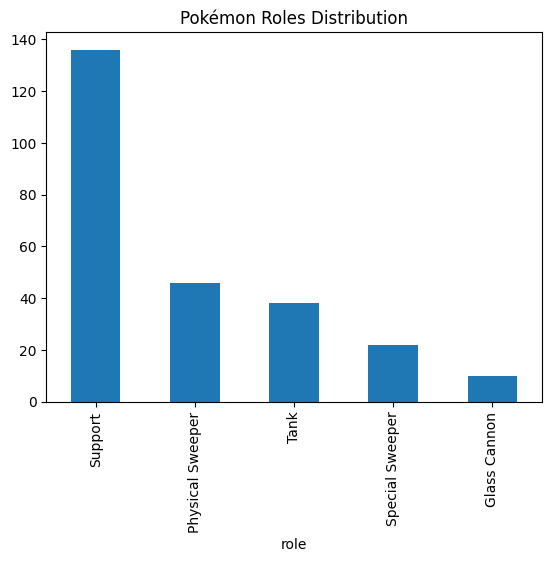

In [46]:
df["role"].value_counts().plot(kind="bar", title="Pokémon Roles Distribution")

In [29]:
df.head(7)

,hp,attack,defense,special-attack,special-defense,speed,name,types,weaknesses,role
0,80,82,83,100,100,80,Venusaur,"grass, poison","{fire, flying, psychic, bug, ice, poison, ground}",Special Sweeper
1,78,84,78,109,85,100,Charizard,"fire, flying","{rock, ice, electric, water, ground}",Special Sweeper
2,79,83,100,85,105,78,Blastoise,water,"{electric, grass}",Support
3,60,45,50,90,80,70,Butterfree,"bug, flying","{fire, flying, rock, ice, electric}",Support
4,65,90,40,45,80,75,Beedrill,"bug, poison","{fire, flying, psychic, rock, ground}",Support
5,83,80,75,70,70,101,Pidgeot,"normal, flying","{electric, rock, fighting, ice}",Support
6,55,81,60,50,70,97,Raticate,normal,{fighting},Support
